# Downlaod after defining asset on platform 

In [8]:
#load username, password amd test connection
import dotenv
dotenv.load_dotenv('platform.env')

from kayrros_platform.tests import test_connection
test_connection()

<Response [200]>

In [28]:
from tqdm import tqdm
import pandas as pd
from joblib import Parallel,delayed 
import os
import rasterio
from kayrros_platform.result.platform_results import get_crops


ASSET_ID ='h9lq7gqbvgqo7m768non95wgfw1vqjz7'
# ASSET_ID = '8b43df04531f23d572b0bd3aa95949a9' #fordead
dir = '/Users/arthurcalvi/Data/disturbances-ex/france/for-itsr-noaoi/s1'
bands = ["iw-vh", "iw-vv"]
start = 2017
end = 2023
normalization = lambda x: x * 255

def writing(row, dir, bands):
    """Write memory file in uint8 
    0 is nodata
    1 to 255 is the available data range

    Args:
        row (pd.DataFrame ): row from pd.DataFrame(get_crop(...)['result'])
        dir (StringIO): directory for writing
        bands (list): list of bands to write
    """
    d = row['metadata']
    print(d)
    date = d['product_id'].split('_')[4][:8]
    basename = "_".join([date, d['product_id'].split('_')[0], \
            d['product_type'], d['orbit_direction'], \
                str(d['relative_orbit_number']), d['product_id'].split('_')[-1]] )
    
    os.makedirs(os.path.join(dir, basename), exist_ok=True)
    try :
        for band in bands:
            file_dir = os.path.join(dir, basename, basename + f'_{band}.tif')
            pr = row[band].open().profile
            pr['dtype'] = 'uint8'
            pr['nodata'] = 0 
            with rasterio.open(file_dir, 'w', **pr) as dw:
                dw.write(normalization(row[band].open().read()).astype('uint8'))

        return 1
    except:
        return 0

In [29]:
raw_bands = get_crops(asset_id=ASSET_ID, bands=bands,
                         source="sentinel1-grd",
                           start_date=f'2017-01-01', end_date=f'2017-02-28',
                           download=True, output_tiffs=True
                         )
df = pd.DataFrame(raw_bands['result']).T.sort_index()

In [11]:
writing(df.iloc[0], dir, bands)

IndexError: single positional indexer is out-of-bounds

In [4]:
#download

timeperiod = range(start, end+1)
gc = []
for year in tqdm(timeperiod):
    raw_bands = get_crops(asset_id=ASSET_ID, bands=bands,
                         source="sentinel1-grd",
                           start_date=f'{year}-01-01', end_date=f'{year}-12-31',
                           download=True, output_tiffs=True
                         )
    df = pd.DataFrame(raw_bands['result']).T.sort_index()
    
    count = Parallel(n_jobs=6, prefer="threads", verbose=5)\
            (delayed(writing)(df.iloc[i], dir, bands) for i in range(df.shape[0]))
    gc.extend(count)

print(f'coverage : {sum(gc)/len(gc) : .2%}')

  0%|          | 0/7 [00:00<?, ?it/s]

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   0 out of   0 | elapsed:    0.0s finished
 14%|█▍        | 1/7 [00:07<00:44,  7.42s/it][Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   0 out of   0 | elapsed:    0.0s finished
 29%|██▊       | 2/7 [00:14<00:35,  7.02s/it][Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   0 out of   0 | elapsed:    0.0s finished
 43%|████▎     | 3/7 [00:22<00:29,  7.49s/it][Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   0 out of   0 | elapsed:    0.0s finished
 57%|█████▋    | 4/7 [00:29<00:21,  7.31s/it][Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   0 out of   0 | elapsed:    0.0s finished
 71%|███████▏  | 5/7 [00:37<00:15,  7.60s/it][Parallel(n_jobs=6)]: Usi

ZeroDivisionError: division by zero

In [113]:
#ensure same AOI (polygon and crs)
scrs = set()
spolygon = set()
for folder in os.listdir(dir):
    dir_folder = os.path.join(dir, folder)
    if not dir_folder.__contains__('.'):
        for file in os.listdir(dir_folder):
            path = os.path.join(dir_folder, file)
            raster = rasterio.open(path)
            scrs.add(raster.crs)
            spolygon.add(raster.bounds)


print(scrs)
print(spolygon)

{CRS.from_epsg(32631)}
{BoundingBox(left=639540.0, bottom=5449740.0, right=646200.0, top=5454960.0)}


In [20]:
#compute VH/VV ratio -> better to compute i inside fordead
import os
import rasterio 
from tqdm import tqdm
dir = '/Users/arthurcalvi/Data/fordead_data-main/fordead_data-main-update_study_area/study_area_s1'
normalization = lambda x: (x - 0) / (1 - 0) * (255 - 1) + 1
for folder in tqdm(os.listdir(dir)):
    dir_folder = os.path.join(dir, folder)
    if not dir_folder.__contains__('.'):
        l = [os.path.join(dir_folder, file) for file in os.listdir(dir_folder)]
        l.sort()
        arrays = [rasterio.open(file).read() for file in l]
        ratio = (np.sqrt(arrays[1] / (arrays[1] + arrays[0])) * (4*arrays[0]/(arrays[0] + arrays[1]))).clip(0,1)
        pr = rasterio.open(l[0]).profile
        file_dir = os.path.join(dir, folder, folder + 'RVI.tif')
        with rasterio.open(file_dir, 'w', **pr) as dw:
                dw.write(normalization(ratio).astype('uint8'))
        

  0%|          | 0/259 [00:00<?, ?it/s]/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_6394/3131869965.py:13: RuntimeWarning: divide by zero encountered in divide
  ratio = (np.sqrt(arrays[1] / (arrays[1] + arrays[0])) * (4*arrays[0]/(arrays[0] + arrays[1]))).clip(0,1)
  5%|▌         | 13/259 [00:00<00:11, 20.61it/s]/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_6394/3131869965.py:13: RuntimeWarning: invalid value encountered in divide
  ratio = (np.sqrt(arrays[1] / (arrays[1] + arrays[0])) * (4*arrays[0]/(arrays[0] + arrays[1]))).clip(0,1)
100%|██████████| 259/259 [00:13<00:00, 18.95it/s]


In [ ]:
#separate asc and dsc
import shutil
import os
from tqdm import tqdm
input_directory = "/Users/arthurcalvi/Data/fordead_data-main/fordead_data-main-update_study_area/study_area_s1"
dst_asc = "/Users/arthurcalvi/Data/fordead_data-main/fordead_data-main-update_study_area/study_area_s1_asc"
dst_desc = "/Users/arthurcalvi/Data/fordead_data-main/fordead_data-main-update_study_area/study_area_s1_desc"
for folder in tqdm(os.listdir(input_directory)):
    if folder.__contains__('desc'):
        shutil.copytree(os.path.join(input_directory, folder), os.path.join(dst_desc, folder), dirs_exist_ok=True)
    elif folder.__contains__('asc'):
        shutil.copytree(os.path.join(input_directory, folder), os.path.join(dst_asc, folder), dirs_exist_ok=True)

100%|██████████| 259/259 [00:00<00:00, 652.23it/s]


In [5]:
import numpy as np
l = [os.path.join(dir_folder, file) for file in os.listdir(dir_folder)]
arrays = [rasterio.open(file).read() for file in l]
rvi = (np.sqrt(arrays[1] / (arrays[1] + arrays[0])) * (4*arrays[0]/(arrays[0] + arrays[1])))

/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_6394/639816135.py:4: RuntimeWarning: divide by zero encountered in divide
  rvi = (np.sqrt(arrays[1] / (arrays[1] + arrays[0])) * (4*arrays[0]/(arrays[0] + arrays[1])))
/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_6394/639816135.py:4: RuntimeWarning: invalid value encountered in divide
  rvi = (np.sqrt(arrays[1] / (arrays[1] + arrays[0])) * (4*arrays[0]/(arrays[0] + arrays[1])))


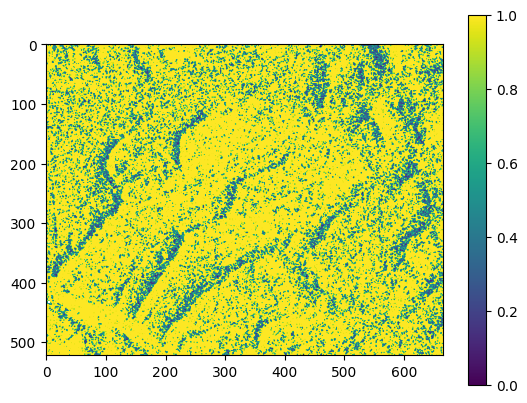

In [8]:
import matplotlib.pyplot as plt 
plt.imshow(rvi.squeeze().clip(0,1))
plt.colorbar()